## Stock Price Prediction
In this project we are going to create a machine learning algorithm which will predict the stock prices.The stocks are bought if the algorithm predicts that the prices will go down.

We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.


## Method
Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

1. Download historical stock prices from Yahoo finance
2. Explore the data
3. Setup the dataset to predict future prices using historical prices
4. Test a machine learning model
5. Setup a backtesting engine
6. Improve the accuracy of the model
 At the end, we'll document some potential future directions we can go in to improve the technique.

In [1]:
!pip install yfinance
import yfinance as yf  # yfinance package that enables us to fetch historical market data from Yahoo Finance API in a Pythonic way

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
msft = yf.Ticker("MSFT") # use ticker object to access the ticker data
msft = msft.history(period="max")   #A stock ticker reports transaction and price data for a security, updated continuously throughout the day.

In [4]:
msft.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055783,0.063987,0.055783,0.061252,1031788800,0.0,0.0
1986-03-14,0.061252,0.064533,0.061252,0.063439,308160000,0.0,0.0
1986-03-17,0.063439,0.065080,0.063439,0.064533,133171200,0.0,0.0
1986-03-18,0.064533,0.065080,0.062345,0.062892,67766400,0.0,0.0


In [5]:
#msft_array = np.array(msft['Close']) # converted the data points into array using nummpy

In [6]:
#plt.xlabel("Date")
#plt.ylabel("Stock Price")
#plt.plot(msft_array, linestyle = 'dotted') # used plt.plot to draw a line graph of closing stock points


<AxesSubplot:xlabel='Date'>

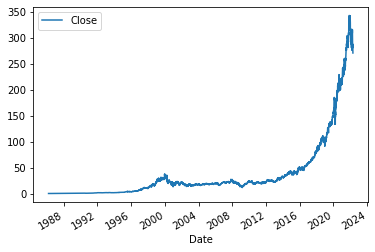

In [7]:
msft.plot.line(y='Close', use_index=True) # use_index will manage the x axis of the msft Close column

In [8]:
data = msft[['Close']] ## double brackets are used to get the column names
data = data.rename(columns={'Close':'Actual_Close'})
data['Target'] = msft.rolling(2).apply(lambda x : x.iloc[1] > x.iloc[0])['Close'] # The rolling() function is used to provide rolling window calculations.

In [9]:
data.head(4)

,Actual_Close,Target
Date,,
1986-03-13,0.061252,NaN
1986-03-14,0.063439,1.0
1986-03-17,0.064533,1.0
1986-03-18,0.062892,0.0


In [10]:
data.dropna()

,Actual_Close,Target
Date,,
1986-03-14,0.063439,1.0
1986-03-17,0.064533,1.0
1986-03-18,0.062892,0.0
1986-03-19,0.061799,0.0
1986-03-20,0.060158,0.0
...,...,...
2022-04-20,286.359985,1.0
2022-04-21,280.809998,0.0
2022-04-22,274.029999,0.0


In [11]:
msft_prev = msft.copy()

In [12]:
msft_prev = msft_prev.shift(1) # we don't want to predict at the current date thats why we shift the row

In [13]:
msft_prev.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055783,0.063987,0.055783,0.061252,1.031789e+09,0.0,0.0
1986-03-17,0.061252,0.064533,0.061252,0.063439,3.081600e+08,0.0,0.0
1986-03-18,0.063439,0.065080,0.063439,0.064533,1.331712e+08,0.0,0.0
1986-03-19,0.064533,0.065080,0.062345,0.062892,6.776640e+07,0.0,0.0


In [14]:
predictors = ["Close", "High","Open","Low", "Volume"]
msft_prev[predictors]

,Close,High,Open,Low,Volume
Date,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.061252,0.063987,0.055783,0.055783,1.031789e+09
1986-03-17,0.063439,0.064533,0.061252,0.061252,3.081600e+08
1986-03-18,0.064533,0.065080,0.063439,0.063439,1.331712e+08
1986-03-19,0.062892,0.065080,0.064533,0.062345,6.776640e+07
...,...,...,...,...,...
2022-04-20,285.299988,286.170013,279.380005,278.410004,2.229770e+07
2022-04-21,286.359985,289.700012,289.399994,285.369995,2.290670e+07
2022-04-22,280.809998,293.299988,288.579987,280.059998,2.945460e+07


In [15]:
data = data.join(msft_prev[predictors], lsuffix='_left',rsuffix = '_right').iloc[1:] #If we have a column with the same name in both the DataFrames we are trying to join using the DataFrame.join() method, we get an error with the message ValueError: columns overlap but no suffix specified. We can set the values of lsuffix and rsuffix parameters in the DataFrame.join() method to solve the error.

In [16]:
data.head(5)

,Actual_Close,Target,Close,High,Open,Low,Volume
Date,,,,,,,
1986-03-14,0.063439,1.0,0.061252,0.063987,0.055783,0.055783,1.031789e+09
1986-03-17,0.064533,1.0,0.063439,0.064533,0.061252,0.061252,3.081600e+08
1986-03-18,0.062892,0.0,0.064533,0.065080,0.063439,0.063439,1.331712e+08
1986-03-19,0.061799,0.0,0.062892,0.065080,0.064533,0.062345,6.776640e+07
1986-03-20,0.060158,0.0,0.061799,0.063439,0.062892,0.061252,4.789440e+07


## Training the Machine Learning Model

In [17]:
from sklearn.ensemble import RandomForestClassifier 
# random forest is a good machine learning model that is robust to overfitting and can provide non linear relations if parameters are set properly.
#Here a classifier is used instead of regression as the target variable is binary.

In [18]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 200, random_state = 1)                                        # n_estimators indicate how many individual trees we want to train.
                                                                                                                 # minimum samples prevent the tree from overfitting(model overfitting performs well on training data but not on test data)
                                                                                                                 #  random state is set so that algorithm doesnt give the same result twice

In [19]:
train = data.iloc[:-100]
test  = data.iloc[-100:]

model.fit(train[predictors],train["Target"])

data['Target'].value_counts()

1.0    4603
0.0    4501
Name: Target, dtype: int64

In [20]:
from sklearn.metrics import precision_score

In [21]:
preds = model.predict(test[predictors])
preds

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.])

In [22]:
preds = pd.Series(preds , index = test.index)
preds

Date
2021-12-02    1.0
2021-12-03    1.0
2021-12-06    1.0
2021-12-07    1.0
2021-12-08    1.0
             ... 
2022-04-20    0.0
2022-04-21    0.0
2022-04-22    1.0
2022-04-25    1.0
2022-04-26    1.0
Length: 100, dtype: float64

In [23]:
precision_score(test['Target'], preds) # precision score is used so that we can maximise our precision and minimize the losses while 

0.48314606741573035

In [24]:
combined = pd.concat({"Target":test["Target"],"Predictions":preds},axis = 1)

In [25]:
combined

,Target,Predictions
Date,,
2021-12-02,0.0,1.0
2021-12-03,0.0,1.0
2021-12-06,1.0,1.0
2021-12-07,1.0,1.0
2021-12-08,1.0,1.0
...,...,...
2022-04-20,1.0,0.0
2022-04-21,0.0,0.0
2022-04-22,0.0,1.0


<AxesSubplot:xlabel='Date'>

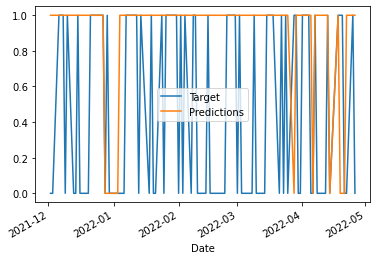

In [26]:
combined.plot()

# Creating the Backtesting

In [27]:
#Backtesting is the general method for seeing how well a strategy or model would have done ex-post. Backtesting assesses the viability of a trading strategy by discovering how it would play out using historical data. If backtesting works, traders and analysts may have the confidence to employ it going forward.

In [156]:
# backtesting enables us to determine error on every single row in our dataset which makes it much better and much more reliable
start = 1000
step = 750    # lower the steps for better prediction
def backtest(data , model , predictors , start = 1000, step = 750):
    predictions = []

    for i in range(start,data.shape[0], step):

        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors],train["Target"])
        preds = model.predict_proba(test[predictors])[:,1] # 1d array
        preds = pd.Series(preds, index= test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({'Target':test['Target'], "Predictions":preds} , axis = 1)
        predictions.append(combined)
    predictions = pd.concat(predictions)
    return predictions

In [157]:
train

,Actual_Close,Target,Close,High,Open,Low,Volume
Date,,,,,,,
1986-03-14,0.063439,1.0,0.061252,0.063987,0.055783,0.055783,1.031789e+09
1986-03-17,0.064533,1.0,0.063439,0.064533,0.061252,0.061252,3.081600e+08
1986-03-18,0.062892,0.0,0.064533,0.065080,0.063439,0.063439,1.331712e+08
1986-03-19,0.061799,0.0,0.062892,0.065080,0.064533,0.062345,6.776640e+07
1986-03-20,0.060158,0.0,0.061799,0.063439,0.062892,0.061252,4.789440e+07
...,...,...,...,...,...,...,...
2019-11-25,148.094574,1.0,146.488571,147.183857,146.958630,145.734546,1.590180e+07
2019-11-26,148.877960,1.0,148.094574,148.212096,146.890080,146.811736,2.242090e+07
2019-11-27,149.161942,1.0,148.877960,149.259874,148.221853,148.182689,2.462010e+07


In [158]:
model.fit(train[predictors],train["Target"])
preds = model.predict_proba(test[predictors])[:,1]

In [159]:
preds #contains 1d array which shows that the price will go up 

array([0.50387288, 0.51142006, 0.52633073, 0.51633073, 0.50633073,
       0.50633073, 0.50633073, 0.50863953, 0.48290154, 0.48290154,
       0.48290154, 0.48290154, 0.48290154, 0.48290154, 0.47693383,
       0.49781221, 0.50169696, 0.50169696, 0.50012102, 0.50169696,
       0.50012102, 0.49053615, 0.47926926, 0.47926926, 0.47926926,
       0.48535436, 0.47926926, 0.48567925, 0.47926926, 0.4860388 ,
       0.47926926, 0.48290154, 0.50083709, 0.48535436, 0.48290154,
       0.50126545, 0.48290154, 0.49811854, 0.48290154, 0.50083709,
       0.47693383, 0.50083709, 0.48316785, 0.50083709, 0.50083709,
       0.48535436, 0.50083709, 0.50083709, 0.47693383, 0.47693383,
       0.50083709, 0.4860388 , 0.48535436, 0.48316785, 0.50083709,
       0.47693383, 0.47585169, 0.47585169, 0.47693383, 0.48101965,
       0.48101965, 0.48101965, 0.48101965, 0.47693383, 0.47693383,
       0.48101965, 0.47585169, 0.4777628 , 0.47693383, 0.4699846 ,
       0.47703014, 0.60118168, 0.51122817, 0.49795468, 0.46269

In [160]:
 predictions["Predictions"].value_counts() # 674 days we predicted that price will go up and 7366 days we predicted that price will go down

0.0    7595
1.0     144
Name: Predictions, dtype: int64

# Improving the accuracy of model

In [161]:
precision_score(predictions['Target'],predictions["Predictions"])

0.5625

In [162]:
# we will add more predictors so that i will give more columns to the algorithm to make a better function

In [163]:
weekly_mean = data.rolling(7).mean()  #the weekely rolling price will have a relation that is it is higher or lower than weekly price
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

In [164]:
weekly_trend = data.shift(1).rolling(7).mean()["Target"] # weekly on an average what is the percentage chance that the price will go up

In [165]:
weekly_trend

Date
1986-03-14         NaN
1986-03-17         NaN
1986-03-18         NaN
1986-03-19         NaN
1986-03-20         NaN
                ...   
2022-04-20    0.428571
2022-04-21    0.571429
2022-04-22    0.571429
2022-04-25    0.571429
2022-04-26    0.571429
Name: Target, Length: 9104, dtype: float64

In [166]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]




In [167]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [168]:
precision_score(predictions["Target"], predictions["Predictions"] )

0.5882352941176471

In [169]:
predictions["Predictions"].value_counts()

0.0    7535
1.0     204
Name: Predictions, dtype: int64

## Conclusion/Further Improvement
After performing back testing and including more predictors our model accuracy increased to 58 percent which can further be increased by taking the following measures.
1. Run with a reduced step size! This will take longer, but increase accuracy
2. Try a different machine learning algorithm
3. Try discarding older data (only keeping data in a certain window)
4. Tweak random forest parameters, or the prediction threshold